In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'

## Combine data frames

In [18]:
def sanity_check(df):
    print df.shape
    print "num formulas: %d" % (df.shape[0] / 21)
    print "parity: %d" % float(df.shape[0] % 21)

In [19]:
dfa = pd.read_csv('joined15.csv')
dfb = pd.read_csv('joined1617.csv')
sanity_check(dfa)
sanity_check(dfb)

(861, 15)
num formulas: 41
parity: 0
(441, 15)
num formulas: 21
parity: 0


In [4]:
df = dfa.append(dfb, ignore_index=True)
sanity_check(df)

(1302, 15)
num formulas: 62
parity: 0


In [5]:
df[df.duplicated(subset=['experiment','solver', 'formula'])]

,experiment,solver,formula,variables,clauses,runtime,conflicts,decisions,restarts,propagations,entropy,backbone,num_sols,chi_square,cpu_time


No duplicated formulas from 15,16,17 competitions

## Perform data preperation

In [6]:
df.head()

,experiment,solver,formula,variables,clauses,runtime,conflicts,decisions,restarts,propagations,entropy,backbone,num_sols,chi_square,cpu_time
0,exp2,COMiniSatPS-6,40bits_10.dimacs.cnf,446,12980,61.07870,224458,255797,475.0,16165613,0.130045,0.869955,2.0,0.0,4.79127
1,exp2,COMiniSatPS-5,40bits_10.dimacs.cnf,446,12980,36.70640,234944,274595,367.0,14949163,0.130045,0.869955,2.0,0.0,4.79127
2,exp5,wrapper-60,40bits_10.dimacs.cnf,446,12980,15.73160,117363,154663,356.0,4992154,0.130045,0.869955,2.0,0.0,4.79127
3,exp4,wrapper-glucose,40bits_10.dimacs.cnf,446,12980,2.13967,26069,32948,64.0,979665,0.130045,0.869955,2.0,0.0,4.79127
4,exp2,COMiniSatPS-4,40bits_10.dimacs.cnf,446,12980,48.07070,222780,258214,319.0,15949794,0.130045,0.869955,2.0,0.0,4.79127


### Timeout formulas (Oh's experiments)

In [7]:
# timeout formulas (for Oh's experiments)
df[df['variables'] == 0]

,experiment,solver,formula,variables,clauses,runtime,conflicts,decisions,restarts,propagations,entropy,backbone,num_sols,chi_square,cpu_time
637,exp2,COMiniSatPS-5,aes_32_3_keyfind_1.cnf,0,0,0.0,0,0,0.0,0,0.0,1.0,1.0,0.0,2709.81
638,exp2,COMiniSatPS-6,aes_32_3_keyfind_1.cnf,0,0,0.0,0,0,0.0,0,0.0,1.0,1.0,0.0,2709.81
647,exp2,COMiniSatPS-4,aes_32_3_keyfind_1.cnf,0,0,0.0,0,0,0.0,0,0.0,1.0,1.0,0.0,2709.81
1265,exp2,COMiniSatPS-6,aes_32_3_keyfind_2.cnf,0,0,0.0,0,0,0.0,0,0.0,1.0,1.0,0.0,1973.15


In [14]:
# find timeout formulas
terminated_formulas = set()
terminated_indices = list() 
for index, row in df[df['variables'] <= 0].iterrows():
    terminated_formulas.add(row['formula'])
    terminated_indices.append(index)

print terminated_formulas
print terminated_indices
df[df['formula'].isin(terminated_formulas)].sort_values(by=['formula','experiment','solver']).to_csv('two_timedout_formulas.csv')

set(['aes_32_3_keyfind_2.cnf', 'aes_32_3_keyfind_1.cnf'])
[637, 638, 647, 1265]


#### find all terminated indices (for all other experiments too), or should we just delete those rows?

In [ ]:
#df.drop(terminated_indices, inplace=True)
#sanity_check(df)

will delete them below

### Check formulas runtime statistics across all engines

In [15]:
variables = df.groupby('formula')['variables'].mean()
entropy = df.groupby('formula')['entropy'].mean()
means = df.groupby('formula')['runtime'].mean()
medians = df.groupby('formula')['runtime'].median()
stds = df.groupby('formula')['runtime'].std()
series_list = [ entropy,variables, means, medians, stds]
statsdf = pd.concat(series_list, axis=1)
statsdf.columns=['entropy', 'variables','mean', 'median', 'std']
statsdf.sort_values('entropy')

,entropy,variables,mean,median,std
formula,,,,,
gss-20-s100.cnf,0.000000,31503.000000,2922.011857,1380.240000,3268.099980
manthey_single-ordered-initialized-w12-b6.cnf,0.000000,792.000000,0.018950,0.013997,0.027491
manthey_single-ordered-initialized-w14-b7.cnf,0.000000,1225.000000,0.027568,0.026995,0.026170
gss-18-s100.cnf,0.000000,31364.000000,551.239451,532.625000,358.031024
manthey_single-ordered-initialized-w20-b10.cnf,0.000000,3400.000000,0.129845,0.085986,0.143185
aes_32_3_keyfind_2.cnf,0.000000,674.285714,12135.998429,2486.220000,19675.299486
aes_32_3_keyfind_1.cnf,0.000000,606.857143,6796.592819,2000.050000,11727.218960
vmpc_29.cnf,0.000000,841.000000,558.079186,315.502000,752.228640
mp1-klieber2017s-0500-023-t12.cnf,0.000000,30587.000000,616.614338,455.527000,608.412865


# Formulas entropy histogram
### (20 bins)

In [ ]:
statsdf['entropy'].hist(bins=20)
print('Num formulas:%d' % statsdf.shape[0])

### Remove formulas with runtime mean and std < 1 second (and terminated formulas too)

In [16]:
formulas_to_remove = list(statsdf[(statsdf['mean'] < 15)].index)
#formulas_to_remove += list(terminated_formulas)
print('formulas_to_remove', len(formulas_to_remove))
print('expected #rows', len(formulas_to_remove)*21)
indices = list()
for index, row in df.iterrows():
    if row['formula'] in formulas_to_remove:
        indices.append(index)
print(len(indices))
print('before ', df.shape)
df.drop(indices, inplace=True)
print('after ', df.shape)

('formulas_to_remove', 14)
('expected #rows', 294)
294
('before ', (1302, 15))
('after ', (1008, 15))


In [20]:
sanity_check(df)

(1008, 15)
num formulas: 48
parity: 0


## Add solution density

In [26]:

df['solution_density'] = df.apply(lambda x: (math.log(x['num_sols'], 2) / x['variables']) if x['variables'] > 0 else None , axis=1)

## Number of unique formulas

In [33]:
formulas_set = set()
for index, row in df.iterrows():
    formulas_set.add(row['formula'])

print(len(formulas_set))

48


# Helpers for experiments

In [27]:
def create_secondary_dataframe(df, exp, formulas_set, a_val, b_val):
    """
        Creates a secondary data frame for checking runtime diffs
        columns = ['formula', 'entropy', 'solution_density', 'backbone', 'diff', 
                    'diff_perecent', 'runtime_a', 'runtime_b']
        a_val and b_val are the actual solvers
        diff is a_runtime - b_runtime
    """
    # get experiment
    exp_df = df[df['experiment'] == exp]
    # create df
    columns = ['formula', 'entropy', 'solution_density', 'backbone', 
               'diff', 'diff_perecent', 'runtime_a', 'runtime_b']
    out_df = pd.DataFrame(columns=columns)

    for index, f in enumerate(formulas_set):
        # get formula,solver row
        df_a = exp_df[(df['formula'] == f) & (df['solver'] == a_val)]
        df_b = exp_df[(df['formula'] == f) & (df['solver'] == b_val)]
        # should have 1 rows after manipulation
        assert(df_a.shape[0] == 1)
        assert(df_b.shape[0] == 1)
        runtime_a, runtime_b = df_a.iloc[0]['runtime'], df_b.iloc[0]['runtime']
        diff = df_a.iloc[0]['runtime'] - df_b.iloc[0]['runtime']
        
        #diff_perecent = runtime_b / runtime_a
        
        if runtime_b < runtime_a:
            diff_perecent = runtime_a / runtime_b
        elif runtime_a < runtime_b:
            diff_perecent = -runtime_b / runtime_a
        else:
            diff_perecent = 0
        
        out_df.loc[index] = [f, 
                              df_a.iloc[0]['entropy'], 
                              df_a.iloc[0]['solution_density'],
                              df_a.iloc[0]['backbone'],
                              diff,
                              diff_perecent,
                              runtime_a, # runtime a
                              runtime_b # runtime b
                             ]
    return out_df

In [28]:
def plotter(df, exp, formulas_set, a_val, b_val, x_property, x_lim=None, y_lim=None, opts='regression'):
    """
        Plot diff (a_val - b_val) with x as x_property (could be entropy, num_sols, backbone)
    """
    exp_df = create_secondary_dataframe(df, exp, formulas_set, a_val, b_val)
    x = exp_df[x_property]
    y = exp_df['diff']
    # scatter
    plt.plot(x , y, 'ro')
    # regression line
    if opts == 'regression':
        m, b = np.polyfit(x, y, 1)
        plt.plot(x, m*x + b, '-')
    # add lines: distance for x=0
    elif opts == 'lines':
        for index, values in y:
            pass # TODO
    if x_lim:
        plt.xlim(x_lim)
    if y_lim:
        plt.ylim(y_lim)
    plt.xlabel(str(x_property))
    plt.ylabel('Runtime (seconds)')
    title = 'Delta runtime: ' + str(a_val) + '-' + str(b_val)
    plt.title(title)
    plt.show()

In [29]:
def plotter_entropy_sols_sharingy(df, exp, formulas_set, a_val, b_val, perecent=True):
    """
        Two subplots sharing Y
    """
    exp_df = create_secondary_dataframe(df, exp, formulas_set, a_val, b_val)
    if perecent:
        y = exp_df['diff_perecent']
    else:
        y = exp_df['diff']
    
    # config 2 plots
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    # first plot (entropy)
    x = exp_df['entropy']
    ax1.scatter(x, y)
    # add regression line
    m, b = np.polyfit(x, y, 1)
    ax1.plot(x, m*x + b, '-')
    # settings
    ax1.set_xlabel('entropy')
    ax1.set_ylabel('Runtime (seconds)')
    title1 = 'Delta runtime: ' + str(a_val) + '-' + str(b_val)
    ax1.set_title(title1)
    ax1.autoscale_view()
    
    # second plot (density)
    x = exp_df['solution_density']
    ax2.scatter(x, y)
    # add regression line
    m, b = np.polyfit(x, y, 1)
    ax2.plot(x, m*x + b, '-')
    # settings
    ax2.set_xlabel('solution_density')
    ax2.set_ylabel('Runtime (seconds)')
    title2 = 'Delta runtime: ' + str(a_val) + '-' + str(b_val)
    ax2.set_title(title1)
    ax2.autoscale_view()
    
    plt.show()

In [30]:
def entropy_sols_plotter(df, exp, formulas_set, a_val, b_val):
    plotter(df, exp, formulas_set, a_val, b_val, 'entropy', x_lim=(0,df['entropy'].max()))
    plotter(df, exp, formulas_set, a_val, b_val, 'solution_density', x_lim=(0,df['solution_density'].max()))

In [69]:
def plotter_3d(df, exp, formulas_set, a_val, b_val):
    create_secondary_dataframe(df, exp, formulas_set, a_val, b_val)
    fig = plt.figure()
    ax = fig.add_subplot(121, projection='3d')
    axb = fig.add_subplot(122, projection='3d')
    ax.scatter(exp1_df['runtime_a'], exp1_df['entropy'], exp1_df['runtime_b'],)
    ax.set_xlabel('CPU(Sec): %s' % a_val)
    ax.set_zlabel('CPU(Sec): %s' % b_val)
    ax.set_ylabel('Entropy')
    ax.autoscale_view()
    axb.scatter(exp1_df['runtime_a'], exp1_df['solution_density'], exp1_df['runtime_b'])
    axb.set_xlabel('CPU(Sec): %s' % a_val)
    axb.set_zlabel('CPU(Sec): %s' % b_val)
    axb.set_ylabel('Solution density')
    axb.autoscale_view()
    plt.show()

# Exp1 - Database reduction: (With - Without)

## Plots

/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


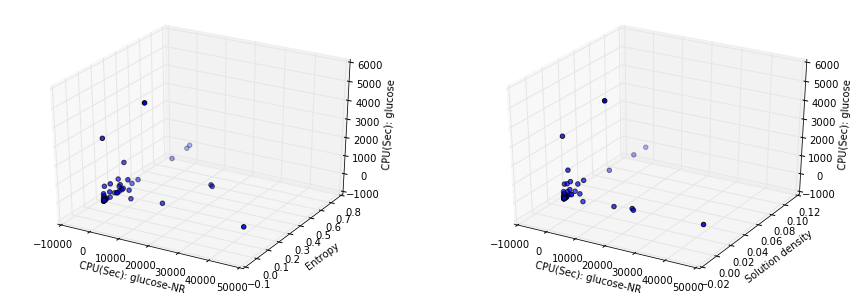

In [70]:
plotter_3d(df, 'exp1', formulas_set, 'glucose-NR', 'glucose')

There's high variation with low entropy (and low density), and it stabilizes as entropy increases.

# Exp2: Controlling lbd-cut (LBD1 - LBD5)

/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in double_scalars


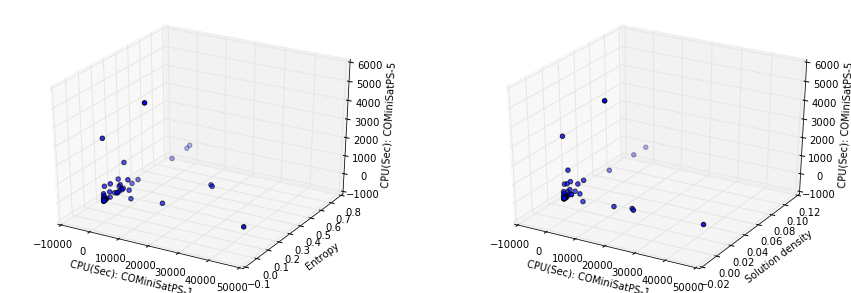

In [71]:
plotter_3d(df, 'exp2', formulas_set, 'COMiniSatPS-1', 'COMiniSatPS-5')

Entropy trend same as our paper, about solution density we can tell there's high variation in low density formulas.

## LBD0 - LBD5

/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in double_scalars


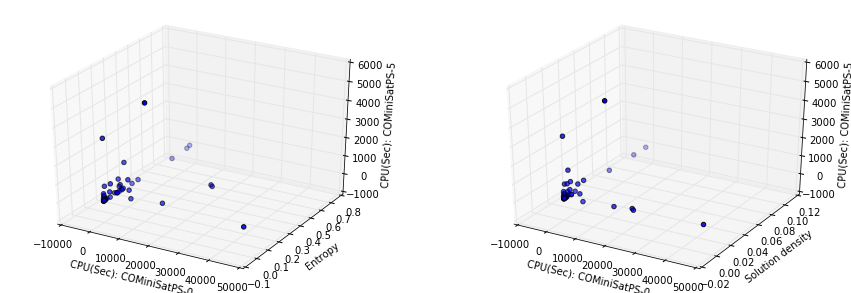

In [72]:
plotter_3d(df, 'exp2', formulas_set, 'COMiniSatPS-0', 'COMiniSatPS-5')

Same as before (but density trend is different)

# Exp3 - Saving criterion - Clause-size - Lbd

/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


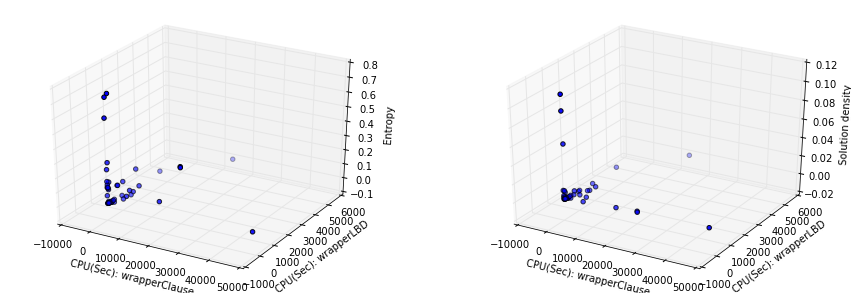

In [66]:
plotter_3d(df, 'exp3', formulas_set, 'wrapperClause', 'wrapperLBD')

The variation is more significant with low entropy and low density. Trends aren't like our paper (but maybe it's early to decide)

# Exp4 - Restarts type (Luby - Glucose)

/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


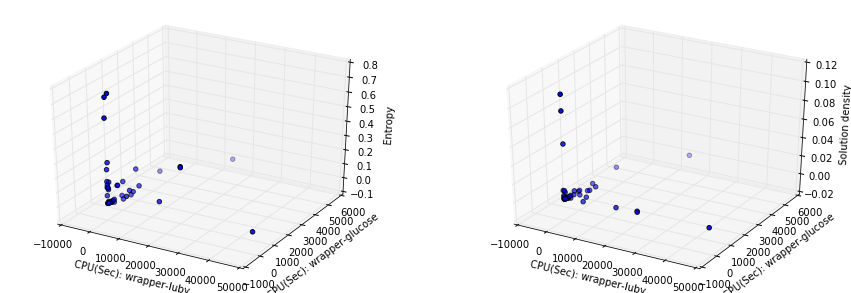

In [67]:
plotter_3d(df, 'exp4', formulas_set, 'wrapper-luby', 'wrapper-glucose')

Same trend as our paper

# Exp5 - Variable decay factor (G0.6 - G0.95)

/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/deebee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


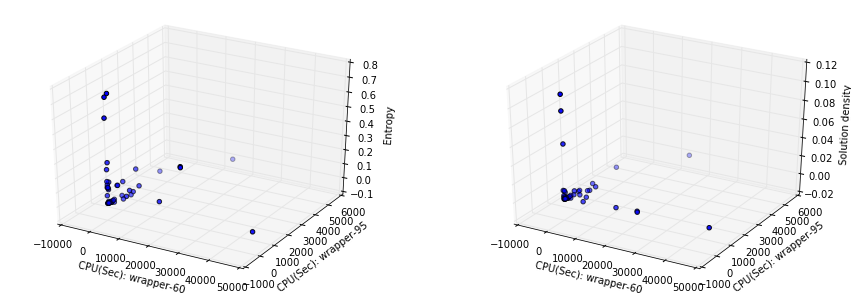

In [68]:
plotter_3d(df, 'exp5', formulas_set, 'wrapper-60', 'wrapper-95')

For low entropy there's high variation, for high entropy the diff is low.

About density - same as our paper

# Summary

The trends aren't 100% same as our paper (but not that different), although we have more formulas to add (2016-2017) to our dataset

I think we should emphasize the large variation between the engines for low entropy, and small variation for high entropy. 

Why should we care about it? The entropy/solution density could be a new measure for the hardness of SATISFIABLE formulas. If for example we work in the industry on some kind of formula, we could run the entropy (solution density) approximator once to tell us if the formula has high or low entropy (solution density). Another scenario: tell something about the competitions formulas (do they have small entropy on average?).

TODO:
* We should filter formulas with runtime < 15 seconds (?)



## How large is the variation between all engines (for entropy/density < threshold)?

Global variation (all entropies)

In [ ]:
print(df['entropy'].mean(), df['entropy'].std())

Low entropy

In [ ]:
def threshold_mean_std(df, threshold, prop):
    print 'low %s' % prop
    print 'mean %lf, std %lf' % (df[df[prop] < threshold][prop].mean(),
                                 df[df[prop] < threshold][prop].std())
    print 'high %s' % prop
    print 'mean %lf, std %lf' % (df[df[prop] >= threshold][prop].mean(),
                                 df[df[prop] >= threshold][prop].std())

In [ ]:
for thres in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
    print 'threshold: %lf' % thres
    threshold_mean_std(df, thres, 'entropy')
    print

Notice how the standard deviation is increasing for low entropy and decreasing for high entropy, as we increase the threshold.

In [ ]:
for thres in [0.01, 0.05, 0.1, 0.15, 0.2]:
    print 'threshold: %lf' % thres
    threshold_mean_std(df, thres, 'solution_density')
    print

Same goes for solution density, although we don't have much diversity in its values.